In [1]:
import os
import torch
from torch import nn
from torchvision import transforms
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pylab as plt
import torchvision
import torchvision.transforms.functional as F

In [2]:
torch.backends.cudnn.benchmark = True

In [2]:
image_split_size = 128#64
image_size = -1#500

In [4]:
def image_chunks(image_path, chunk_size=128, downscale=False):
    img = Image.open(image_path)
    width, height = img.size
    if downscale:
        width = width//4
        height = height//4
        chunk_size = chunk_size//4
        img = img.resize((width, height))

    chunks = []
    for i in range(0, height, chunk_size):
        for j in range(0, width, chunk_size):
            chunk = F.crop(img, i, j, chunk_size, chunk_size)
            chunks.append(torchvision.transforms.ToTensor()(chunk)[:3,:,:])
    return chunks

In [5]:
def load_images(image_size=-1):
    path = "DIV2K_train_LR_bicubic/X2/"
    hq = []
    lq = []
    images = os.listdir(path)
    for file in tqdm(images[:len(images) if image_size == -1 else image_size]):
        hq.append(image_chunks(path+file, chunk_size=image_split_size))
        lq.append(image_chunks(path+file, chunk_size=image_split_size, downscale=True))

    hq = [torch.cat([x.unsqueeze(0) for x in y], 0) for y in hq]
    lq = [torch.cat([x.unsqueeze(0) for x in y], 0) for y in lq]
    
    return hq, lq

In [6]:
target_data,test_data = load_images(image_size)

100%|██████████| 822/822 [00:33<00:00, 24.26it/s]


Text(0.5, 1.0, 'hq')

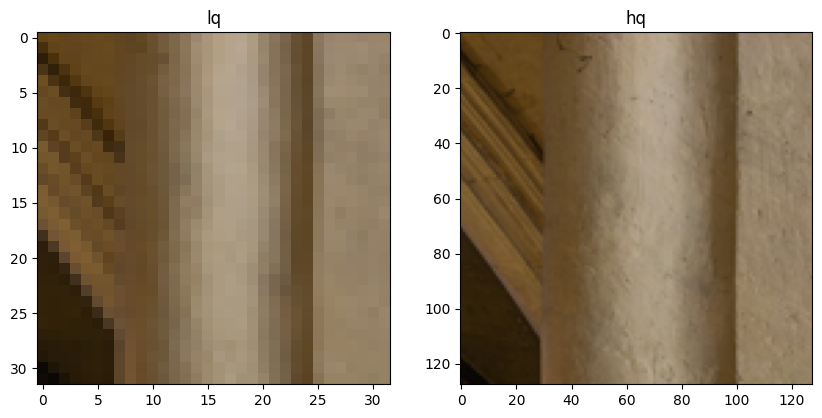

In [7]:
import matplotlib.pyplot as plt

image_idx = 2
idx = 8

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(test_data[image_idx][idx].permute(1,2,0))
axes[0].set_title('lq')

axes[1].imshow(target_data[image_idx][idx].permute(1,2,0))
axes[1].set_title('hq')

In [6]:
class attn_block(nn.Module):
    def __init__(self, ch_in, act=nn.LeakyReLU()):
        super(attn_block, self).__init__()
        self.channels = 32

        self.conv1 = nn.Conv2d(ch_in, self.channels, 3,1,1)
        self.conv2 = nn.Conv2d(ch_in, self.channels, 5,1,2)

        self.attn_map = nn.Sequential(
            act,
            nn.Conv2d(self.channels, ch_in, 3, 1, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)

        attn_map = self.attn_map(x1+x2)
        return (x * attn_map) + x


class resblock(nn.Module):
    def __init__(self, ch_in):
        super(resblock, self).__init__()
        self.act = nn.LeakyReLU()
        self.block = nn.Sequential(
            nn.Conv2d(ch_in, 16, 3, 1, 1),
            self.act,
            nn.Conv2d(16, 32, 3, 1, 1),
            self.act,
            nn.Conv2d(32, ch_in, 3, 1, 1),
            self.act,
        )
    def forward(self, x): return self.block(x) + x

class unet(nn.Module):
    def __init__(self, ch_in):
        super(unet, self).__init__()
        self.act = nn.LeakyReLU()
        self.channels = 32
        self.d = nn.ModuleList(
                 [nn.Sequential(nn.Conv2d(ch_in, self.channels, 2, 2), self.act),
                  nn.Sequential(nn.Conv2d(self.channels, self.channels*2, 2, 2), self.act),
                  nn.Sequential(nn.Conv2d(self.channels*2, self.channels*3, 2, 2), self.act),
                  ])
        self.mid = nn.ModuleList(
                   [nn.Sequential(attn_block(self.channels*3), resblock(self.channels*3), nn.Conv2d(self.channels*3,self.channels*3,3,1,1),self.act),
                    nn.Sequential(attn_block(self.channels*2), resblock(self.channels*2), nn.Conv2d(self.channels*2,self.channels*2,3,1,1),self.act),
                    nn.Sequential(attn_block(self.channels), resblock(self.channels), nn.Conv2d(self.channels,self.channels,3,1,1),self.act),
                    ])
        self.u = nn.ModuleList(
                 [nn.Sequential(nn.ConvTranspose2d(self.channels*3, self.channels*2, 4,2,1),self.act),
                  nn.Sequential(nn.ConvTranspose2d(self.channels*2, self.channels, 4,2,1),self.act),
                  nn.Sequential(nn.ConvTranspose2d(self.channels, ch_in, 4,2,1),self.act),
                  ])
    def forward(self, x):
        d1 = self.d[0](x)
        d2 = self.d[1](d1)

        d3 = self.d[2](d2)
        d3 = self.mid[0](d3)

        u1 = self.u[0](d3)
        u1 = self.mid[1](u1) + d2

        u2 = self.u[1](u1)
        u2 = self.mid[2](u2) + d1

        u3 = self.u[2](u2)

        return u3 + x



class upscaler(nn.Module):
    def __init__(self):
        super(upscaler, self).__init__()
        self.act = nn.LeakyReLU()

        self.up = nn.Sequential(
            nn.Conv2d(3, 15, 3,1,1,groups=3),
            self.act,
            attn_block(15),
            resblock(15),
            resblock(15),
            nn.Conv2d(15, 15, 3, 1, 1),
            self.act,

            nn.ConvTranspose2d(15, 30, 4,2,1),
            self.act,
            nn.Conv2d(30, 30, 3,1,1,groups=3),
            self.act,
            attn_block(30),
            resblock(30),
            resblock(30),
            nn.Conv2d(30, 30, 3, 1, 1),
            self.act,

            nn.ConvTranspose2d(30, 60, 4,2,1),
            self.act,
            nn.Conv2d(60, 15, 3,1,1,groups=3),
            self.act,
            attn_block(15),
            resblock(15),
            resblock(15),
        )
        self.unets = nn.Sequential(*[unet(15) for _ in range(8)])
        
        self.conv_last = nn.Sequential(
            nn.Conv2d(15, 30, 3, 1, 1, groups=3),
            self.act,
            nn.Conv2d(30, 3, 3, 1, 1, groups=3),
        )
    def forward(self, x):
        x = self.up(x)
        x = self.unets(x)
        x = self.conv_last(x)
        return x

In [10]:
if 0:
    with torch.no_grad():
        m = upscaler().cuda()
        btest = test_data[0][:2].cuda()
        print(btest.shape)
        print(m(btest).shape)

In [11]:
batch_size = 32#64
test_data = [x[:batch_size].cuda() for x in test_data]
target_data = [x[:batch_size].cuda() for x in target_data]

In [12]:
m = upscaler().cuda()
loss = nn.MSELoss()
optim = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optim, step_size=3, gamma=0.75)

all_loss = []
epoch_size = len(target_data)

for e in range(50):
    for i in (pbar := tqdm(range(epoch_size))):
        out = m(test_data[i])
        loss_out = loss(out, target_data[i])
        loss_out.backward()
        all_loss.append(loss_out.item())
        optim.step()
        optim.zero_grad()
        pbar.set_description(f"loss {loss_out.item():.6f}")
    if e<18: scheduler.step()
    avg_loss = sum(all_loss[epoch_size*e:epoch_size*(e+1)]) / epoch_size
    print(f"e: {e+1:2d} | average loss: {avg_loss:.6f}")

  0%|          | 0/822 [00:00<?, ?it/s]

loss 0.011037: 100%|██████████| 822/822 [05:59<00:00,  2.28it/s]


e:  1 | average loss: 0.021669


loss 0.003493: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e:  2 | average loss: 0.007726


loss 0.003124: 100%|██████████| 822/822 [05:40<00:00,  2.42it/s]


e:  3 | average loss: 0.007571


loss 0.002814: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e:  4 | average loss: 0.005957


loss 0.001984: 100%|██████████| 822/822 [05:21<00:00,  2.56it/s]


e:  5 | average loss: 0.005539


loss 0.001691: 100%|██████████| 822/822 [05:19<00:00,  2.57it/s]


e:  6 | average loss: 0.005064


loss 0.001427: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e:  7 | average loss: 0.004308


loss 0.001320: 100%|██████████| 822/822 [05:38<00:00,  2.43it/s]


e:  8 | average loss: 0.004376


loss 0.001319: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e:  9 | average loss: 0.004264


loss 0.001186: 100%|██████████| 822/822 [05:27<00:00,  2.51it/s]


e: 10 | average loss: 0.004042


loss 0.001159: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e: 11 | average loss: 0.004012


loss 0.001158: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e: 12 | average loss: 0.004031


loss 0.001027: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e: 13 | average loss: 0.003875


loss 0.001053: 100%|██████████| 822/822 [05:34<00:00,  2.46it/s]


e: 14 | average loss: 0.003861


loss 0.001046: 100%|██████████| 822/822 [05:49<00:00,  2.35it/s]


e: 15 | average loss: 0.003847


loss 0.000945: 100%|██████████| 822/822 [06:04<00:00,  2.26it/s]


e: 16 | average loss: 0.003771


loss 0.000928: 100%|██████████| 822/822 [06:07<00:00,  2.24it/s]


e: 17 | average loss: 0.003746


loss 0.000925: 100%|██████████| 822/822 [06:07<00:00,  2.24it/s]


e: 18 | average loss: 0.003725


loss 0.000896: 100%|██████████| 822/822 [05:37<00:00,  2.43it/s]


e: 19 | average loss: 0.003684


loss 0.000881: 100%|██████████| 822/822 [05:32<00:00,  2.47it/s]


e: 20 | average loss: 0.003663


loss 0.000868: 100%|██████████| 822/822 [05:32<00:00,  2.47it/s]


e: 21 | average loss: 0.003648


loss 0.000853: 100%|██████████| 822/822 [05:31<00:00,  2.48it/s]


e: 22 | average loss: 0.003632


loss 0.000842: 100%|██████████| 822/822 [05:32<00:00,  2.47it/s]


e: 23 | average loss: 0.003619


loss 0.000831: 100%|██████████| 822/822 [05:37<00:00,  2.43it/s]


e: 24 | average loss: 0.003606


loss 0.000824: 100%|██████████| 822/822 [05:26<00:00,  2.52it/s]


e: 25 | average loss: 0.003588


loss 0.000820: 100%|██████████| 822/822 [05:39<00:00,  2.42it/s]


e: 26 | average loss: 0.003580


loss 0.000809: 100%|██████████| 822/822 [05:23<00:00,  2.54it/s]


e: 27 | average loss: 0.003567


loss 0.000805: 100%|██████████| 822/822 [05:32<00:00,  2.47it/s]


e: 28 | average loss: 0.003555


loss 0.000797: 100%|██████████| 822/822 [05:38<00:00,  2.43it/s]


e: 29 | average loss: 0.003542


loss 0.000791: 100%|██████████| 822/822 [05:38<00:00,  2.43it/s]


e: 30 | average loss: 0.003531


loss 0.000788: 100%|██████████| 822/822 [05:43<00:00,  2.39it/s]


e: 31 | average loss: 0.003521


loss 0.000781: 100%|██████████| 822/822 [05:32<00:00,  2.47it/s]


e: 32 | average loss: 0.003508


loss 0.000776: 100%|██████████| 822/822 [05:48<00:00,  2.36it/s]


e: 33 | average loss: 0.003501


loss 0.000771: 100%|██████████| 822/822 [06:35<00:00,  2.08it/s]


e: 34 | average loss: 0.003486


loss 0.000767: 100%|██████████| 822/822 [06:34<00:00,  2.08it/s]


e: 35 | average loss: 0.003479


loss 0.000762: 100%|██████████| 822/822 [06:36<00:00,  2.07it/s]


e: 36 | average loss: 0.003465


loss 0.000757: 100%|██████████| 822/822 [06:04<00:00,  2.26it/s]


e: 37 | average loss: 0.003459


loss 0.000750: 100%|██████████| 822/822 [07:05<00:00,  1.93it/s]


e: 38 | average loss: 0.003452


loss 0.000757: 100%|██████████| 822/822 [07:09<00:00,  1.91it/s]


e: 39 | average loss: 0.003446


loss 0.000746: 100%|██████████| 822/822 [07:07<00:00,  1.92it/s]


e: 40 | average loss: 0.003440


loss 0.000748: 100%|██████████| 822/822 [05:41<00:00,  2.41it/s]


e: 41 | average loss: 0.003430


loss 0.000741: 100%|██████████| 822/822 [05:51<00:00,  2.34it/s]


e: 42 | average loss: 0.003421


loss 0.000736: 100%|██████████| 822/822 [06:03<00:00,  2.26it/s]


e: 43 | average loss: 0.003413


loss 0.000732: 100%|██████████| 822/822 [06:48<00:00,  2.01it/s]


e: 44 | average loss: 0.003397


loss 0.000729: 100%|██████████| 822/822 [06:49<00:00,  2.01it/s]


e: 45 | average loss: 0.003385


loss 0.000723: 100%|██████████| 822/822 [06:49<00:00,  2.01it/s]


e: 46 | average loss: 0.003379


loss 0.000723: 100%|██████████| 822/822 [06:52<00:00,  1.99it/s]


e: 47 | average loss: 0.003368


loss 0.000715: 100%|██████████| 822/822 [06:28<00:00,  2.12it/s]


e: 48 | average loss: 0.003358


loss 0.000716: 100%|██████████| 822/822 [05:59<00:00,  2.29it/s]


e: 49 | average loss: 0.003357


loss 0.000712: 100%|██████████| 822/822 [05:47<00:00,  2.36it/s]

e: 50 | average loss: 0.003346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


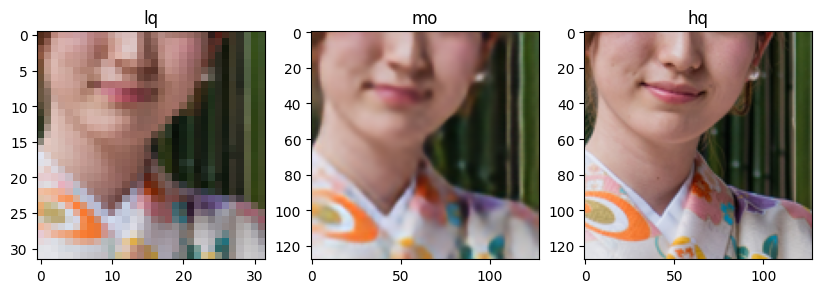

In [8]:
import matplotlib.pyplot as plt
i = 1
out = m(test_data[i])

with torch.no_grad():
    idx = 6
    fig, axes = plt.subplots(1, 3, figsize=(10, 15))

    axes[0].imshow(test_data[i][idx].permute(1,2,0).cpu())
    axes[0].set_title('lq')

    axes[1].imshow(out[idx].cpu().detach().permute(1,2,0).numpy())
    axes[1].set_title('mo')

    axes[2].imshow(target_data[i][idx].permute(1,2,0).cpu())
    axes[2].set_title('hq')